INSTALL FOLIUM DAN CONTEXTILY

In [41]:
!pip install folium

In [42]:
!pip install contextily

IMPORT LIBRARY

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt
import matplotlib.gridspec as gridspec
from scipy.stats import shapiro


LOAD DATASET

In [44]:
from google.colab import drive
drive.mount('/content/drive')

# resd teh CSV file with a comma delimiter
df = pd.read_csv('/content/drive/MyDrive/1.Kuliah/Semester-7/Machine_Learning/Praktikum/Praktikum11/Data/turis-dest.csv')

# Cetak ehader data (5 baris data) dari file
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


DATA CLEANING

In [46]:
df.isnull().sum()

,0
Place_Id,0
Place_Name,0
Description,0
Category,0
City,0
Price,0
Rating,0
Time_Minutes,232
Coordinate,0
Lat,0


In [47]:
df.duplicated().sum()

np.int64(0)

Exploratory Data Analysis (EDA)

VISUALISASI HEATMAP

In [48]:
peta_wisata = folium.Map(location=[-7.5, 110.0], zoom_start=7)
df_heat = df[['Lat', 'Long']].copy()
df_heat['weight'] = 1

# Buat list data [lat, long, value] untuk heatmap
data_heatmap = df_heat.values.tolist()

# Tambahkan heatmap ke peta
HeatMap(data_heatmap, radius=12, blur=15, max_zoom=10).add_to(peta_wisata)

# Tampilkan peta
peta_wisata

PETA SEBARAN TEMPAT WISATA TERBANYAK

In [49]:
np.random.seed(42)

long_peta = df['Long'] + np.random.uniform(-0.05, 0.05, size=len(df))
lat_peta = df['Lat'] + np.random.uniform(-0.05, 0.05, size=len(df))

# Konversi ke GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(long_peta, lat_peta),
    crs='EPSG:4326'    # WGS84 (lat-lon)
)

# Proyeksi ke Web Mercator (untuk visualisasi peta)
gdf = gdf.to_crs(epsg=3857)

# ===== Analisis "kepadatan" sederhana per kota =====
# Jumlah tempat wisata per City
jumlah_wisata_per_kota = df.groupby("City")["Place_Id"].count()

# 5 kota dengan jumlah tempat wisata terbanyak
top_5 = jumlah_wisata_per_kota.sort_values(ascending=False).head(5)

# 5 kota dengan jumlah tempat wisata paling sedikit
bottom_5 = jumlah_wisata_per_kota.sort_values().head(5)

print("Top 5 kota dengan jumlah tempat wisata terbanyak:")
print(top_5)

print("\nBottom 5 kota dengan jumlah tempat wisata paling sedikit:")
print(bottom_5)


Top 5 kota dengan jumlah tempat wisata terbanyak:
City
Yogyakarta    126
Bandung       124
Jakarta        84
Semarang       57
Surabaya       46
Name: Place_Id, dtype: int64

Bottom 5 kota dengan jumlah tempat wisata paling sedikit:
City
Surabaya       46
Semarang       57
Jakarta        84
Bandung       124
Yogyakarta    126
Name: Place_Id, dtype: int64


VISUALISASI PETA DAN GRAFIK BAR

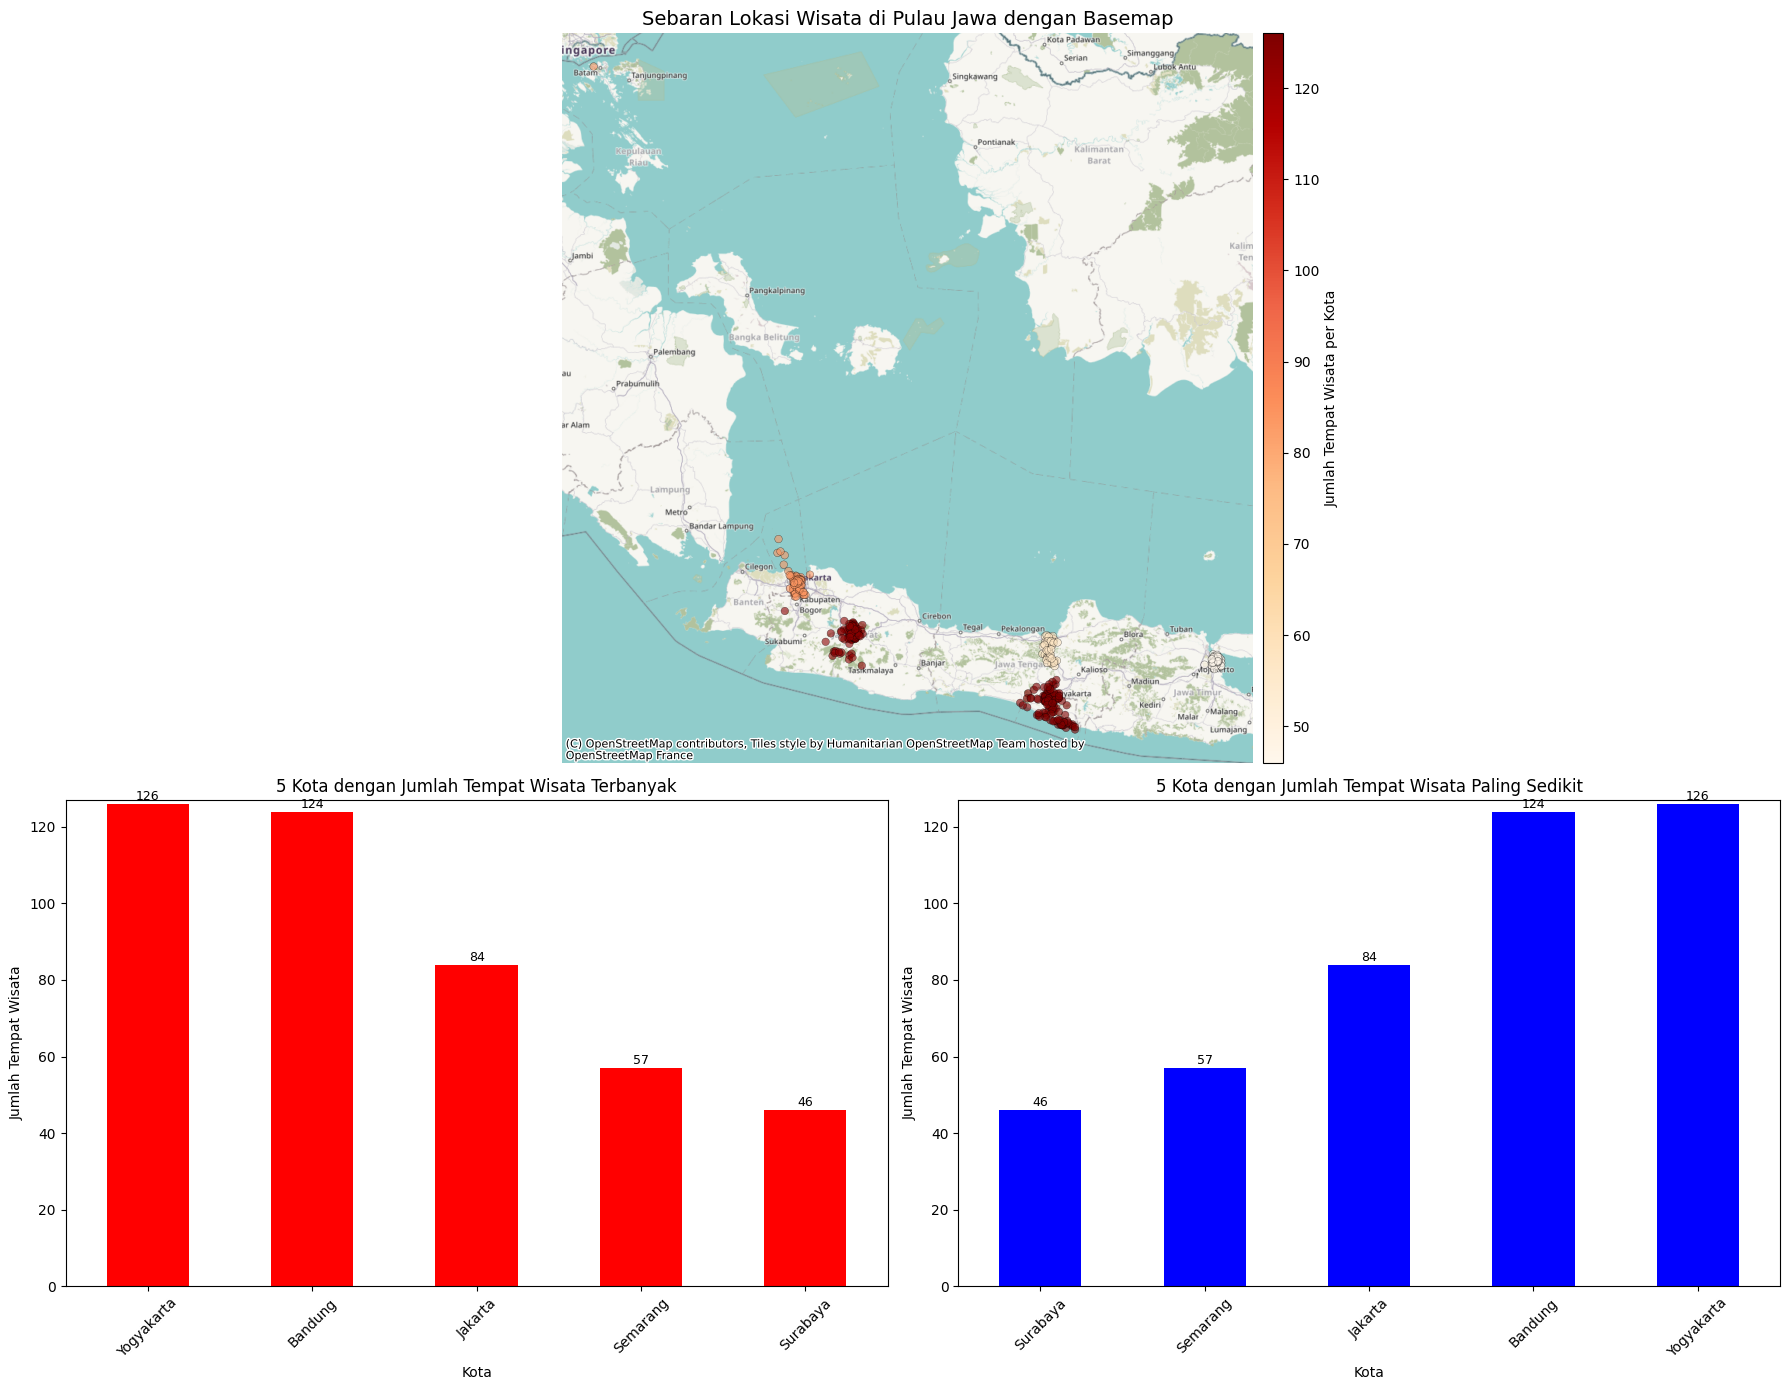

In [53]:
# Buat layout dengan GridSpec
fig = plt.figure(figsize=(18, 14))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 2])

# --- Row 1: Peta sebaran (colspan=2) ---
ax_map = plt.subplot(gs[0, :])
divider = make_axes_locatable(ax_map)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Map the count of places per city to a new column in gdf
gdf['jumlah_wisata_kota'] = gdf['City'].map(jumlah_wisata_per_kota)

gdf.plot(
    ax=ax_map,
    column='jumlah_wisata_kota',  # kolom baru hasil mapping jumlah wisata per kota
    cmap='OrRd',
    legend=True,
    legend_kwds={
        'label': "Jumlah Tempat Wisata per Kota",
        'orientation': 'vertical'
    },
    cax=cax,
    markersize=30,
    edgecolor='black',
    linewidth=0.3,
    alpha=0.6
)

ctx.add_basemap(ax_map)
ax_map.set_title("Sebaran Lokasi Wisata di Pulau Jawa dengan Basemap", fontsize=14)
ax_map.axis('off')

# --- Row 2: Bar chart Top 5 (kiri) ---
ax_top = plt.subplot(gs[1, 0])
bars_top = top_5.plot(kind='bar', ax=ax_top, color='red')
ax_top.set_title("5 Kota dengan Jumlah Tempat Wisata Terbanyak")
ax_top.set_ylabel("Jumlah Tempat Wisata")
ax_top.set_xlabel("Kota")
ax_top.tick_params(axis='x', rotation=45)

# Tambahkan anotasi nilai di atas batang Top 5
for i, val in enumerate(top_5):
    ax_top.text(i, val + 0.2, f"{val}", ha='center', va='bottom', fontsize=9)

# --- Row 2: Bar chart Bottom 5 (kanan) ---
ax_bottom = plt.subplot(gs[1, 1])
bars_bottom = bottom_5.plot(kind='bar', ax=ax_bottom, color='blue')
ax_bottom.set_title("5 Kota dengan Jumlah Tempat Wisata Paling Sedikit")
ax_bottom.set_ylabel("Jumlah Tempat Wisata")
ax_bottom.set_xlabel("Kota")
ax_bottom.tick_params(axis='x', rotation=45)

# Tambahkan anotasi nilai di atas batang Bottom 5
for i, val in enumerate(bottom_5):
    ax_bottom.text(i, val + 0.2, f"{val}", ha='center', va='bottom', fontsize=9)

# Sinkronisasi skala Y kedua chart
max_val = max(top_5.max(), bottom_5.max())
ax_top.set_ylim(0, max_val + 1)
ax_bottom.set_ylim(0, max_val + 1)

plt.tight_layout()
plt.show()

In [55]:
df.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')

UJI NORMALITAS

In [66]:
from scipy.stats import shapiro

# Buat dataframe khusus untuk uji normalitas (drop kolom non-numerik)
normalityTest_df = df[['Price', 'Rating', 'Time_Minutes', 'Lat', 'Long']]

normalityTest_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         437 non-null    int64  
 1   Rating        437 non-null    float64
 2   Time_Minutes  205 non-null    float64
 3   Lat           437 non-null    float64
 4   Long          437 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 17.2 KB


In [69]:
print("\n=== UJI NORMALITAS (SHAPIRO-WILK) ===\n")

stat, p = shapiro(data)

print(f"Kolom: {normalityTest_df}")
print("  Statik : ", stat)
print("  P-value: ", p)

if p > 0.05:
    print("  Kesimpulan: Data berdistribusi normal (tidak tolak H0)\n")
else:
    print("  Kesimpulan: Data tidak berdistribusi normal (tolak H0)\n")


=== UJI NORMALITAS (SHAPIRO-WILK) ===

Kolom:       Price  Rating  Time_Minutes       Lat        Long
0     20000     4.6          15.0 -6.175392  106.827153
1         0     4.6          90.0 -6.137645  106.817125
2    270000     4.6         360.0 -6.125312  106.833538
3     10000     4.5           NaN -6.302446  106.895156
4     94000     4.5          60.0 -6.124190  106.839134
..      ...     ...           ...       ...         ...
432    2000     4.4          45.0 -7.433859  112.719906
433       0     4.6           NaN -7.291347  112.739822
434       0     4.4          45.0 -7.275296  112.754938
435       0     4.6           NaN -7.294330  112.761753
436   10000     4.8           NaN -7.242076  112.736816

[437 rows x 5 columns]
  Statik :  0.8559224179975824
  P-value:  1.320404231654075e-19
  Kesimpulan: Data tidak berdistribusi normal (tolak H0)



CORRELATION MATRIX

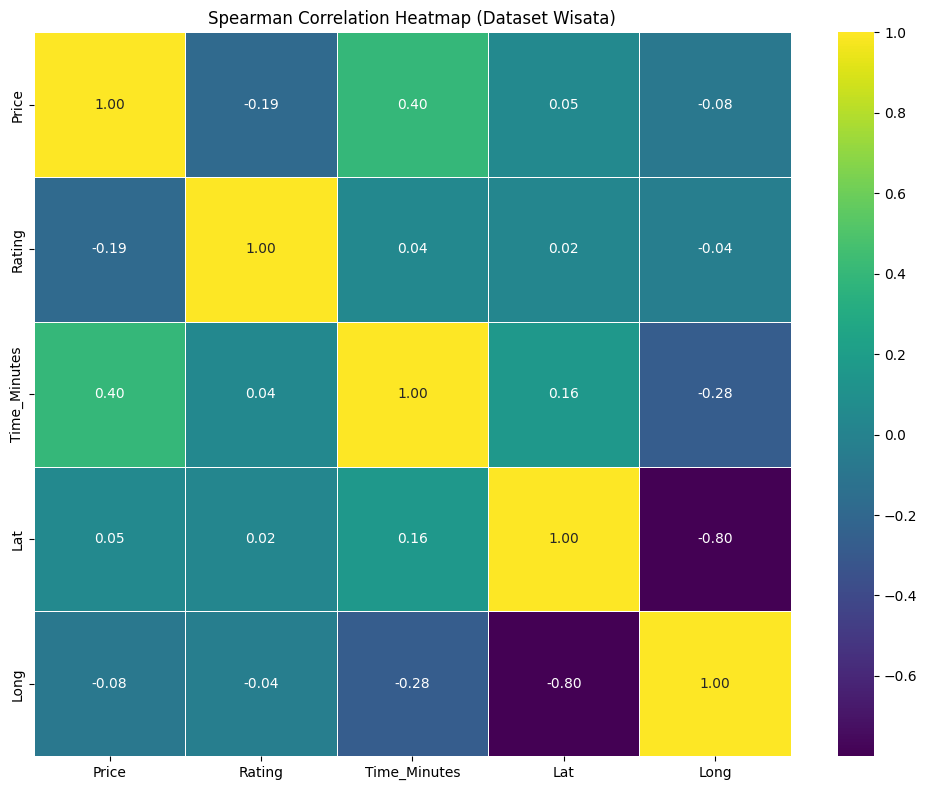

In [70]:
correlation_df = df[['Price', 'Rating', 'Time_Minutes', 'Lat', 'Long']]

correlation_matrix = correlation_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Heatmap (Dataset Wisata)")
plt.tight_layout()
plt.show()

ANALISIS KORELASI SPESIFIK (PRICE VS RATING)

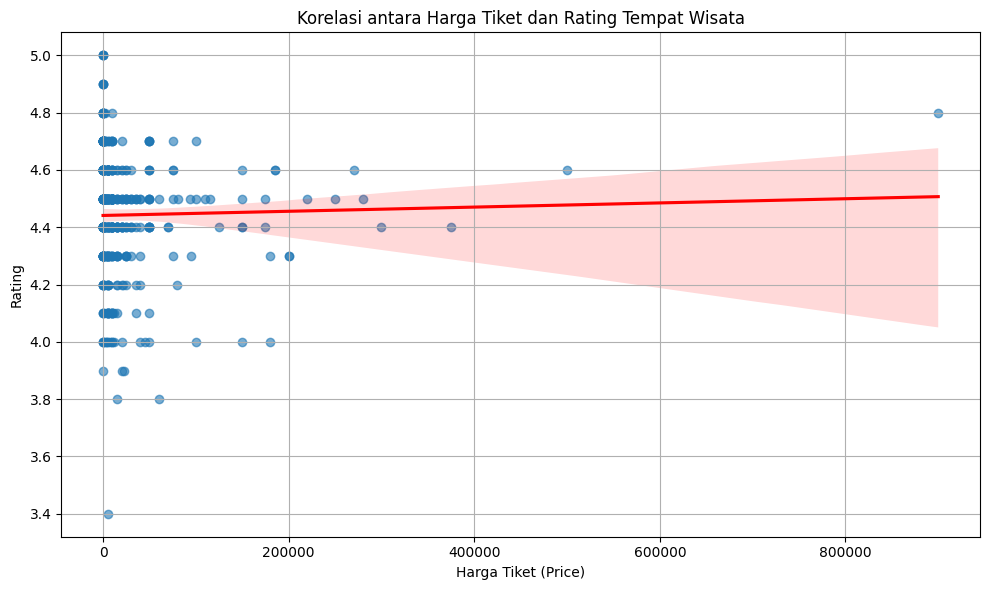

In [71]:
plt.figure(figsize=(10, 6))
sns.regplot(
    x="Price",
    y="Rating",
    data=df,
    scatter_kws={'alpha': 0.6},
    line_kws={"color": "red"}
)

plt.title("Korelasi antara Harga Tiket dan Rating Tempat Wisata")
plt.xlabel("Harga Tiket (Price)")
plt.ylabel("Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


NORMALISASI DATA

PEMILIHAN KOLOM NORMALISASI

In [74]:
from sklearn.preprocessing import RobustScaler

# Memilih kolom yang akan dinormalisasi (koordinat GPS)
normalisasi_df = df[['Lat', 'Long']].copy()

normalisasi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Lat     437 non-null    float64
 1   Long    437 non-null    float64
dtypes: float64(2)
memory usage: 7.0 KB


NORMALISASI DENGAN ROBUSTSCALER

In [73]:
column_names = normalisasi_df.columns

scaler = RobustScaler()
normalisasi_scaled = scaler.fit_transform(normalisasi_df)

normalisasi_scaled = pd.DataFrame(normalisasi_scaled, columns=column_names)
normalisasi_scaled.head()

,Lat,Long
0,0.918443,-1.195134
1,0.959465,-1.198648
2,0.972867,-1.192896
3,0.780368,-1.171302
4,0.974087,-1.190935


MENENTUKAN PARAMETER ε (EPSILON) MENGGUNAKAN K-DISTANCE GRAPH

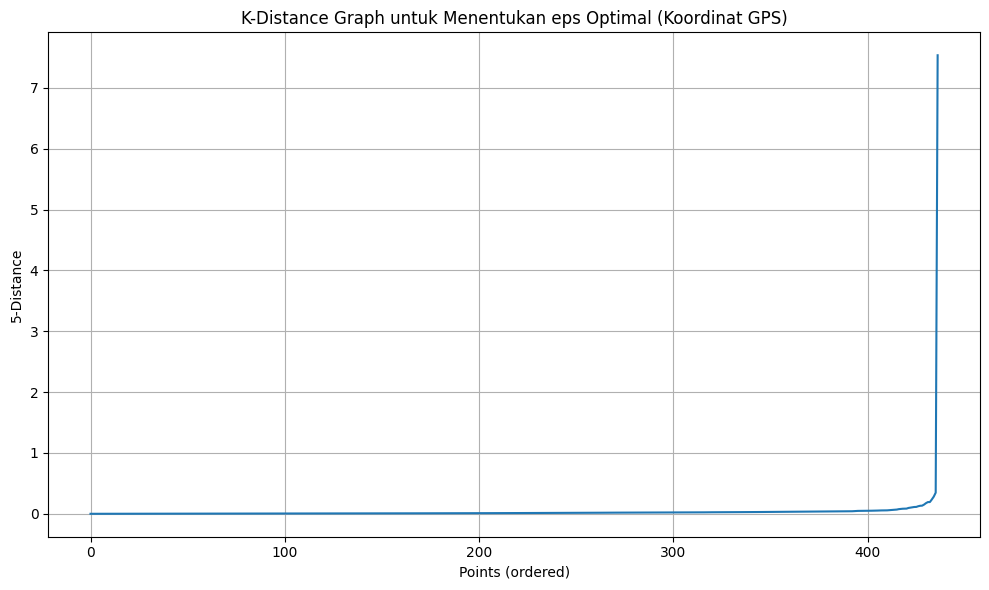

In [76]:
from sklearn.neighbors import NearestNeighbors

# Menggunakan data hasil normalisasi (Lat, Long)
X = normalisasi_scaled.values

# Menentukan jumlah tetangga (min_samples DBSCAN biasanya 4–10)
k = 5

# Fit nearest neighbors
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Ambil jarak tetangga ke-k (k-distance)
k_distances = np.sort(distances[:, k-1])

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title("K-Distance Graph untuk Menentukan eps Optimal (Koordinat GPS)")
plt.ylabel(f"{k}-Distance")
plt.xlabel("Points (ordered)")
plt.grid(True)
plt.tight_layout()
plt.show()

CLUSTERING DENGAN DBSCAN

In [77]:
from sklearn.cluster import DBSCAN

# Bangun model DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Melakukan clustering pada data yang sudah dinormalisasi
labels = dbscan.fit_predict(normalisasi_df.values)

# Simpan label cluster ke dalam dataframe
df["Cluster_DBSCAN"] = labels
print(df["Cluster_DBSCAN"].value_counts())


Cluster_DBSCAN
 1    183
 2    123
 0     84
 3     46
-1      1
Name: count, dtype: int64


EVALUASI KUALITAS CLUSTERING MENGGUNAKAN SILHOUETTE SCORE

In [78]:
from sklearn.metrics import silhouette_score

# Hilangkan noise (label = -1)
mask = labels != -1

# Mengecek dengan 2 cluster berbeda
if len(set(labels[mask])) > 1:
    score = silhouette_score(normalisasi_df.values[mask], labels[mask])
    print("Silhouette Score:", score)
else:
    print("Silhouette Score tidak dapat dihitung karena hanya ada 1 cluster (atau semua noise).")


Silhouette Score: 0.8474825214878805


VISUALISASI HASIL CLUSTERING DENGAN PCA (2D)


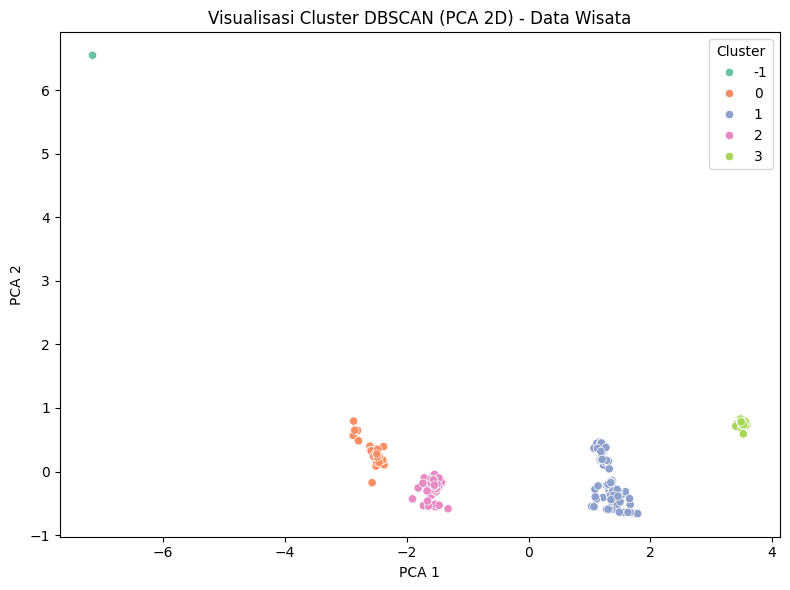

In [79]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# PCA untuk mereduksi data normalisasi (Lat, Long) menjadi 2 dimensi
pca = PCA(n_components=2)
reduced = pca.fit_transform(normalisasi_df.values)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=reduced[:, 0],
    y=reduced[:, 1],
    hue=labels,
    palette="Set2"
)
plt.title("Visualisasi Cluster DBSCAN (PCA 2D) - Data Wisata")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


PENGELOMPOKAN KUALITATIF CLUSTER

In [80]:
def klasifikasi_db(x):
    if x == 0:
        return "Cluster Utama"
    elif x == -1:
        return "Noise"
    else:
        return "Cluster Lain"

df["Klasifikasi_DBSCAN"] = df["Cluster_DBSCAN"].apply(klasifikasi_db)

print(df["Klasifikasi_DBSCAN"].value_counts())

Klasifikasi_DBSCAN
Cluster Lain     352
Cluster Utama     84
Noise              1
Name: count, dtype: int64


ANALISIS LANJUTAN PER CLUSTER (CLUSTER SUMMARY)


In [81]:
# Buang kolom deskriptif yang bukan numerik
cluster_summary_db = df.drop(columns=[
    "Place_Name",
    "Description",
    "Category",
    "City",
    "Coordinate"
], errors="ignore").groupby("Klasifikasi_DBSCAN").mean()

cluster_summary_db


,Place_Id,Price,Rating,Time_Minutes,Lat,Long,Unnamed: 11,Unnamed: 12,Cluster_DBSCAN
Klasifikasi_DBSCAN,,,,,,,,,
Cluster Lain,260.823864,19835.227273,4.430682,79.041916,-7.337828,109.735894,NaN,260.823864,1.610795
Cluster Utama,46.238095,43047.619048,4.494048,98.289474,-6.177024,106.809713,NaN,46.238095,0.000000
Noise,9.000000,175000.000000,4.400000,NaN,1.078880,103.931398,NaN,9.000000,-1.000000


VISUALISASI INTERAKTIF PERSEBARAN CLUSTER (PLOTLY)

In [82]:
import plotly.express as px
import pandas as pd

# Data untuk hover
df_pca_db = pd.DataFrame(reduced, columns=["PCA 1", "PCA 2"])
df_pca_db["Klasifikasi_DBSCAN"] = df["Klasifikasi_DBSCAN"].values
df_pca_db["City"] = df["City"].values   # mirip 'Kabupaten/Kota' di praktikum

# Plotly interaktif
fig = px.scatter(
    df_pca_db,
    x="PCA 1",
    y="PCA 2",
    color="Klasifikasi_DBSCAN",
    hover_name="City",
    title="Persebaran Data Wisata Berdasarkan Klasifikasi DBSCAN",
    width=900,
    height=600
)

fig.show()
